<a href="https://colab.research.google.com/github/vic-torr/thesis-experiments/blob/main/experiments/swin_forest_from_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
RunningInCOLAB = 'google.colab' in sys.modules

In [2]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo virtualenv opencv-python transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 36.9 MB/s 
     |████████████████████████████████| 5.5 MB 41.8 MB/s 
     |████████████████████████████████| 441 kB 61.9 MB/s 
     |████████████████████████████████| 72 kB 129 kB/s 
     |████████████████████████████████| 468 kB 39.1 MB/s 
     |████████████████████████████████| 163 kB 53.3 MB/s 
     |████████████████████████████████| 7.6 MB 25.4 MB/s 
     |████████████████████████████████| 212 kB 54.0 MB/s 
     |████████████████████████████████| 115 kB 58.7 MB/s 
     |████████████████████████████████| 95 kB 5.7 MB/s 
     |████████████████████████████████| 127 kB 56.1 MB/s 
     |████████████████████████████████| 115 kB 54.7 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=2e95409d372e62bb6c5fc0d701c97b8c0e1ea4ea28410e1bf6c4f7c9c619d41f
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/

from huggingface_hub import notebook_login

notebook_login()

%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [3]:
import pandas as pd
import numpy as np # Torch wrapper for Numpy
from PIL import Image
import os
from PIL import Image

import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.preprocessing import MultiLabelBinarizer



In [4]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [5]:
if RunningInCOLAB:  
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    #!unzip /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/drive/MyDrive/Colab-Notebooks/datasets/planet
    !unzip /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/;
    dataset_dir="/content/planet/"
    #dataset_dir="/content/drive/MyDrive/Colab-Notebooks/datasets/planet/"
else:
    home = os.environ['HOME']
    dataset_dir= home+"/UFMG/Thesis/datasets/planet"

Streaming output truncated to the last 5000 lines.
  inflating: /content/planet/train-jpg/train_55.jpg  
  inflating: /content/planet/train-jpg/train_550.jpg  
  inflating: /content/planet/train-jpg/train_5500.jpg  
  inflating: /content/planet/train-jpg/train_5501.jpg  
  inflating: /content/planet/train-jpg/train_5502.jpg  
  inflating: /content/planet/train-jpg/train_5503.jpg  
  inflating: /content/planet/train-jpg/train_5504.jpg  
  inflating: /content/planet/train-jpg/train_5505.jpg  
  inflating: /content/planet/train-jpg/train_5506.jpg  
  inflating: /content/planet/train-jpg/train_5507.jpg  
  inflating: /content/planet/train-jpg/train_5508.jpg  
  inflating: /content/planet/train-jpg/train_5509.jpg  
  inflating: /content/planet/train-jpg/train_551.jpg  
  inflating: /content/planet/train-jpg/train_5510.jpg  
  inflating: /content/planet/train-jpg/train_5511.jpg  
  inflating: /content/planet/train-jpg/train_5512.jpg  
  inflating: /content/planet/train-jpg/train_5513.jpg  
 

In [6]:
!ls $dataset_dir

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


In [7]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [8]:
!ls -1 ~/UFMG/Thesis/datasets/planet/train-jpg | wc -l

ls: cannot access '/root/UFMG/Thesis/datasets/planet/train-jpg': No such file or directory
0


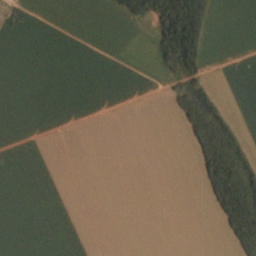

In [9]:
im = Image.open(path_train+'/train_32.jpg')
image_file = im.convert("RGB")
display(image_file)

In [10]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.show()

In [12]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

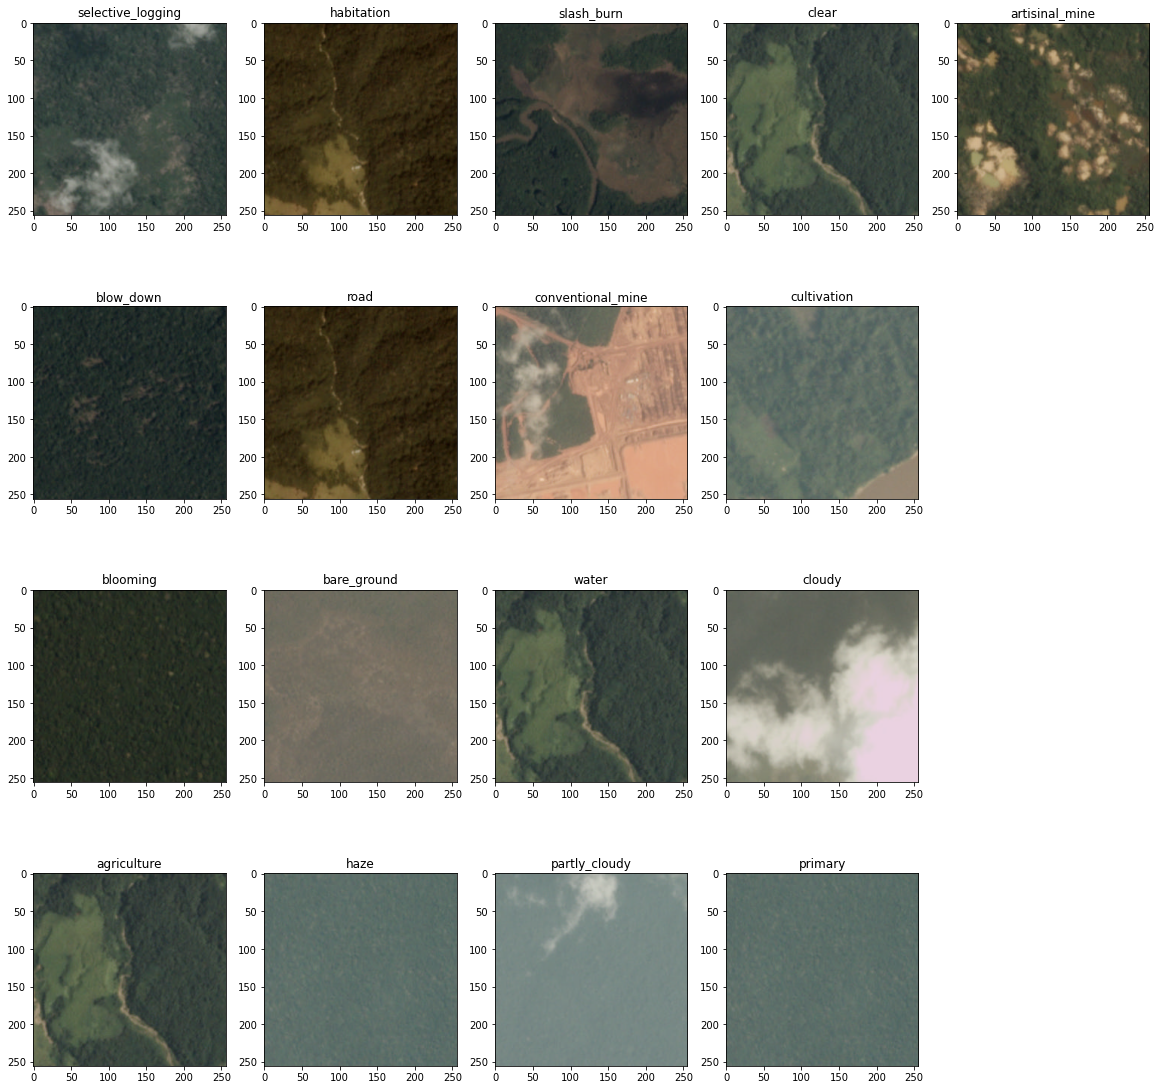

In [13]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [14]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [15]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [16]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

In [17]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=2,
    )
    X_embedded = tsne.fit_transform(X_train_sample)
    X_embedded.shape

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img_tsne);
    plt.axis("off");
#tsne_analysis()    

In [18]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val



In [19]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

In [20]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [21]:
df_train, df_val = train_test_split(df_class, test_size=.2)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



(torch.Size([64, 3, 224, 224]), torch.Size([64, 17]))

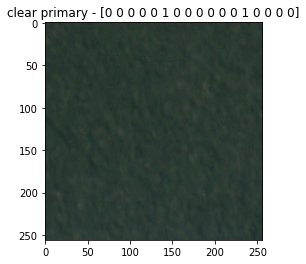

In [22]:
ds_train.load_img(5)

In [23]:
def get_model():
    model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.require_grad = False
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

In [24]:

model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.require_grad = False


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

In [25]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [26]:
from transformers import AutoFeatureExtractor

#loading the feature extractor
model_name = 'microsoft/swin-base-patch4-window7-224'
# model_name = 'zuppif/maskformer-swin-small-ade'
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
feature_extractor

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [43]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs
prepared_ds = ds_train.with_transform(transform)    

AttributeError: ignored

In [29]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224", 
    problem_type="multi_label_classification",
    num_labels=17,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
training_args = TrainingArguments(
    f"swin-finetuned-forest",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=64,
    num_train_epochs=14,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
  )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [32]:
import numpy as np
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
  # function which calculates accuracy for a certain set of predictions
  return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [39]:
print(device)

cuda


In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=ds_train.collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=feature_extractor
)

In [42]:
# Train and save results
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Evaluate on validation set
metrics = trainer.evaluate(ds_val)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running training *****
  Num examples = 32383
  Num Epochs = 14
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 4
  Total optimization steps = 1764
  Number of trainable parameters = 27532427


RuntimeError: ignored

In [ ]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

In [ ]:
idx_fold=0
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

loss_train, loss_val = [], []
score_train, score_val = [], []

Y_hat_val = None
best_loss_val = np.inf

epochs = 14
for idx in range(epochs):
    loss_train_epoch, loss_val_epoch = [], []
    Y_hat_train_epoch, Y_hat_val_epoch = [], []
    Y_train_epoch, Y_val_epoch = [], []

    for X, Y in tqdm(dl_train, leave=False):
        Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
        loss_train_epoch.append(batch_loss)
        Y_hat_train_epoch.extend(Y_hat)
        Y_train_epoch.extend(Y.detach().float().cpu().numpy())

    for X, Y in tqdm(dl_val, leave=False):
        Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
        loss_val_epoch.append(batch_loss)
        Y_hat_val_epoch.extend(Y_hat)
        Y_val_epoch.extend(Y.detach().float().cpu().numpy())
            
    avg_loss_train = np.mean(loss_train_epoch)
    avg_loss_val = np.mean(loss_val_epoch)

    Y_hat_train_epoch = np.array(Y_hat_train_epoch)
    Y_hat_val_epoch = np.array(Y_hat_val_epoch)
    Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
    Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
    Y_train_epoch = np.array(Y_train_epoch)
    Y_val_epoch = np.array(Y_val_epoch)
    
    score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
    score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
            
    # saving values for debugging
    if avg_loss_val < best_loss_val:
        best_loss_val = avg_loss_val
        Y_hat_val = Y_hat_val_epoch
        Y_thresh_val = Y_thresh_val_epoch
        Y_val = Y_val_epoch
        
    loss_train.append(avg_loss_train)
    loss_val.append(avg_loss_val)
    score_train.append(score_train_epoch)
    score_val.append(score_val_epoch)

    print(
        f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
        f"val loss: {avg_loss_val}" \
        f" -- train fbeta_score: {score_train_epoch}, " \
        f"val fbeta_score: {score_val_epoch}"
    )
    
    lr_scheduler.step()

train_results = {
    "loss_train": loss_train,
    "loss_val": loss_val,
    "score_train": score_train,
    "score_val": score_val,
    "Y_hat_val": Y_hat_val,
    "Y_thresh_val": Y_thresh_val,
    "Y_val": Y_val,
}
    
torch.save(model, f"swin_t_fold{idx_fold}.pth")
pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [ ]:
def train_model(dl_train, dl_val, idx_fold, model):
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 14
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [ ]:
train_model(dl_train, dl_val, 0)

In [ ]:
%ls

In [ ]:
#model = torch.load("resnet18_fold0.pth")
#train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [ ]:
oss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

In [ ]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

In [ ]:


def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs



In [ ]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

In [ ]:
!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc -l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l)

In [ ]:
def get_test_data(idx_tta):
    path_test_table = "../input/planets-dataset/planet/planet"
    path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    file_count = len(os.listdir(path_test_file_1)) + len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
    
    assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [ ]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

In [ ]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)